# Stock Price Movement Prediction and Trading Strategy Backtesting Using Machine Learning

In this project, we aim to predict future movements of a stock's closing price using historical stock data and evaluate the performance of trading strategies based on these predictions. We implement and compare multiple machine learning models, perform extensive feature engineering.

---

## **Project Outline**

1. **Import Necessary Libraries**
2. **Load and Preprocess the Dataset**
3. **Exploratory Data Analysis (EDA)**
4. **Feature Engineering**
5. **Prepare Data for Modeling**
6. **Model Development and Comparison**
7. **Model Evaluation**
8. **Hyperparameter Tuning**
9. **Strategy Backtesting**
10. **Visualization of Results**
11. **Conclusion**


In [51]:
# 1. Import Necessary Libraries

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

# Technical indicators library
!pip install ta
import ta

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seaborn style for plots
sns.set_style("darkgrid")


## **2. Loading and Preprocessing the Dataset**

We load the historical stock data from a CSV file into a pandas DataFrame and perform initial preprocessing.




**Explanation:**

- **Loading Data:** We simulate loading data by creating a DataFrame `df` with sample data.
- **Date Conversion and Indexing:**
  - Converts the 'Date' column to datetime format with `dayfirst=True` since the dates are in 'DD-MM-YYYY' format.
  - Sorts the DataFrame by date to ensure chronological order.
  - Sets the 'Date' column as the index for time series analysis.


In [52]:
data = pd.read_csv('reliance_new.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Convert the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Sort data by Date
data.sort_values(by='Date', inplace=True)


# Display the DataFrame
df

,Date,Symbol,Series,Prev_Close,Open,High,Low,Last_Close,VWAP,Volume
0,01-01-1996,RELIANCE,EQ,204.65,205.00,206.10,203.65,205.75,205.26,3717450
1,02-01-1996,RELIANCE,EQ,205.75,205.25,206.25,202.65,204.15,204.13,6024650
2,03-01-1996,RELIANCE,EQ,204.15,207.50,216.95,205.25,205.70,207.04,7473500
3,04-01-1996,RELIANCE,EQ,205.70,203.75,204.40,201.05,203.80,202.47,7744000
4,05-01-1996,RELIANCE,EQ,203.80,203.00,203.00,200.65,202.40,202.05,5952000
...,...,...,...,...,...,...,...,...,...,...
6200,23-11-2020,RELIANCE,EQ,1899.50,1951.00,1970.00,1926.25,1950.70,1952.18,20918665
6201,24-11-2020,RELIANCE,EQ,1950.70,1964.00,1974.00,1932.00,1964.05,1952.11,14277083
6202,25-11-2020,RELIANCE,EQ,1964.05,1980.00,1992.95,1942.20,1947.80,1969.06,15062376
6203,26-11-2020,RELIANCE,EQ,1947.80,1953.05,1965.00,1930.05,1952.60,1946.67,11924527


In [53]:
# Display the first few rows
df.head()

,Date,Symbol,Series,Prev_Close,Open,High,Low,Last_Close,VWAP,Volume
0,01-01-1996,RELIANCE,EQ,204.65,205.00,206.10,203.65,205.75,205.26,3717450
1,02-01-1996,RELIANCE,EQ,205.75,205.25,206.25,202.65,204.15,204.13,6024650
2,03-01-1996,RELIANCE,EQ,204.15,207.50,216.95,205.25,205.70,207.04,7473500
3,04-01-1996,RELIANCE,EQ,205.70,203.75,204.40,201.05,203.80,202.47,7744000
4,05-01-1996,RELIANCE,EQ,203.80,203.00,203.00,200.65,202.40,202.05,5952000


## **3. Exploratory Data Analysis (EDA)**

### **3.1. Visualizing Price Trends**

We plot the closing price over time to observe the general trend of the stock.


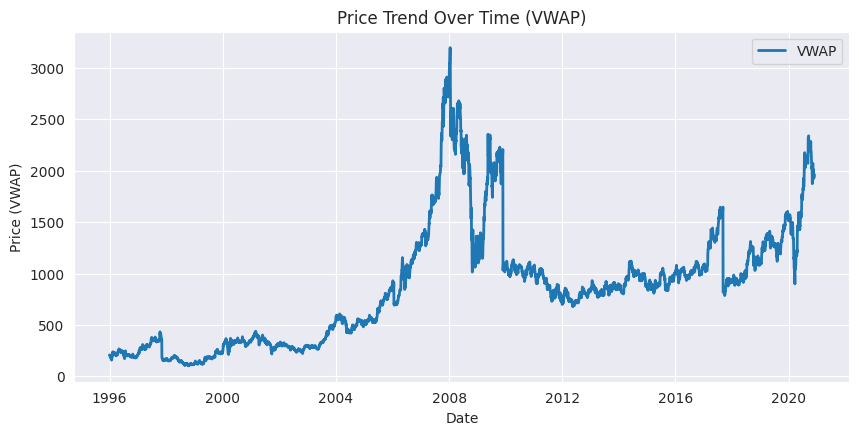

In [54]:
# Plot the VWAP (price trend)
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(data['Date'], data['VWAP'], label='VWAP', linewidth=2)
plt.title('Price Trend Over Time (VWAP)')
plt.xlabel('Date')
plt.ylabel('Price (VWAP)')
plt.grid(True)
plt.legend()
plt.show()


**Explanation:**

- **Plotting:** Creates a line plot of 'Last_Close' prices over time.
- **Visualization Purpose:** Helps identify trends, such as uptrends or downtrends, which are crucial for financial analysis.

### **3.2. Volume Traded Over Time**

We plot the trading volume to assess liquidity and market activity.


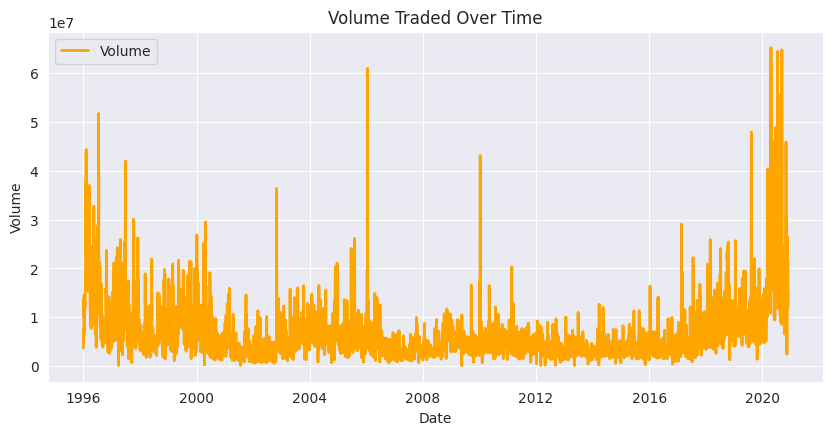

In [55]:
# Plot the Volume
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
plt.plot(data['Date'], data['Volume'], label='Volume', color='orange', linewidth=2)
plt.title('Volume Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()

**Explanation:**

- **Plotting:** Creates a bar chart of 'Volume' over time.
- **Importance:** High trading volume can indicate high interest in the stock, which might be associated with significant price movements.


## **4. Feature Engineering**

We enhance the dataset by adding technical indicators and other features that could improve model performance.

### **4.1. Technical Indicators**

We calculate various technical indicators using the `ta` library.


In [56]:
# Calculate Moving Averages
df['MA_7'] = df['Last_Close'].rolling(window=7).mean()
df['MA_14'] = df['Last_Close'].rolling(window=14).mean()
df['MA_21'] = df['Last_Close'].rolling(window=21).mean()

# Calculate Volatility (Rolling Standard Deviation)
df['Volatility_7'] = df['Last_Close'].rolling(window=7).std()
df['Volatility_14'] = df['Last_Close'].rolling(window=14).std()

# Calculate RSI (Relative Strength Index)
delta = df['Last_Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Percent Changes
df['Pct_Change_Open'] = df['Open'].pct_change()
df['Pct_Change_High'] = df['High'].pct_change()
df['Pct_Change_Low'] = df['Low'].pct_change()
df['Pct_Change_Close'] = df['Last_Close'].pct_change()

# Calculate Volume Features
df['Volume_Change'] = df['Volume'].pct_change()
df['Volume_MA_7'] = df['Volume'].rolling(window=7).mean()

# Drop rows with NaN values introduced by rolling windows
df = df.dropna()





### **4.2. Lag Features**

Including previous days' prices as features can help capture trends.


In [57]:
# Calculate Lagged Features
data['Lag_1'] = data['Last_Close'].shift(1)
data['Lag_2'] = data['Last_Close'].shift(2)


**Explanation:**

- **Lag Features:** The previous days' closing prices.
- **Purpose:** Incorporate past price information to help the model learn temporal dependencies.

### **4.3. Price Differences**

Calculating price changes and percentage changes.


In [58]:
df['Price_Change'] = df['Last_Close'].diff()
df['Pct_Change'] = df['Last_Close'].pct_change()


**Explanation:**

- **Price_Change:** Difference in closing price between consecutive days.
- **Pct_Change:** Percentage change between consecutive closing prices.
- **Utility:** Helps in understanding the price movement's magnitude and direction.

### **4.4. Handling Missing Values**

After feature engineering, we handle any missing values.


In [59]:
df.dropna(inplace=True)
df.head()


,Date,Symbol,Series,Prev_Close,Open,High,Low,Last_Close,VWAP,Volume,...,Volatility_14,RSI,Pct_Change_Open,Pct_Change_High,Pct_Change_Low,Pct_Change_Close,Volume_Change,Volume_MA_7,Price_Change,Pct_Change
21,31-01-1996,RELIANCE,EQ,180.70,179.00,185.75,172.25,176.75,179.43,26118950,...,10.765082,45.512010,0.046784,-0.017196,0.022255,-0.021859,-0.311106,1.964674e+07,-3.95,-0.021859
22,01-02-1996,RELIANCE,EQ,176.75,175.00,185.00,174.50,183.85,180.21,22865050,...,10.259348,46.426352,-0.022346,-0.004038,0.013062,0.040170,-0.124580,2.118610e+07,7.10,0.040170
23,02-02-1996,RELIANCE,EQ,183.85,188.75,206.00,188.75,203.80,196.45,29231000,...,12.515957,58.231707,0.078571,0.113514,0.081662,0.108512,0.278414,2.355171e+07,19.95,0.108512
24,05-02-1996,RELIANCE,EQ,203.80,215.00,225.20,208.55,220.75,216.42,43646350,...,17.280374,65.476190,0.139073,0.093204,0.104901,0.083170,0.493153,2.799571e+07,16.95,0.083170
25,06-02-1996,RELIANCE,EQ,220.75,226.05,230.00,197.60,202.25,218.04,44354450,...,18.359254,56.176359,0.051395,0.021314,-0.052505,-0.083805,0.016224,3.249154e+07,-18.50,-0.083805


**Explanation:**

- **Missing Values:** Arise due to calculations requiring a minimum number of data points.
- **Data Cleaning:** Removes rows with NaN values to ensure model training isn't affected by missing data.


## **5. Preparing Data for Modeling**

### **5.1. Defining the Target Variable**

We define the target variable `y` as the direction of the next day's price movement.


In [60]:
significant_threshold = 0.02  # 2% movement
df['Target'] = np.where(
    df['Last_Close'].shift(-1) > df['Last_Close'] * (1 + significant_threshold), 1,
    np.where(df['Last_Close'].shift(-1) < df['Last_Close'] * (1 - significant_threshold), -1, 0)
)


**Explanation:**

- **Target Variable (`Target`):**
  - **1:** If the next day's closing price is higher than today's.
  - **0:** If the next day's closing price is lower or equal to today's.
- **Data Alignment:** Removes the last row as it doesn't have a corresponding next day's price for the target.

### **5.2. Defining Feature Matrix and Target Vector**


In [61]:
X = df.drop(['Target', 'Volume', 'Prev_Close', 'Price_Change', 'Pct_Change'], axis=1)
y = df['Target']


**Explanation:**

- **Feature Matrix (`X`):** Contains all the engineered features except for:
  - **'Target'**: The variable we aim to predict.
  - **'Volume', 'Prev_Close', 'Price_Change', 'Pct_Change'**: Excluded to prevent data leakage or because they are not predictive in this context.
- **Target Vector (`y`):** The target variable defined earlier.

### **5.3. Splitting Data into Training and Testing Sets**

We use time-series split to prevent data leakage.


In [62]:
X = X.drop(['Date', 'Symbol', 'Series'], axis=1)

split_percentage = 0.8
split = int(split_percentage * len(df))

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]


**Explanation:**

- **Time-Series Split:** Ensures that future data is not used in training.
- **Training Set:** First 80% of the data.
- **Testing Set:** Remaining 20%.

---

## **6. Model Development and Comparison**

We train and compare multiple machine learning models.

### **6.1. Random Forest**


In [63]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**Explanation:**

- **Random Forest:**
  - Ensemble method combining multiple decision trees.
  - Reduces overfitting and improves accuracy.

### **6.2. Gradient Boosting Classifier**


In [64]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

**Explanation:**

- **Gradient Boosting:**
  - Builds trees sequentially to correct errors from previous trees.
  - Effective for capturing complex patterns.


## **7. Model Evaluation**

### **7.1. Making Predictions**


In [65]:
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)


### **7.2. Classification Reports**


In [66]:

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.15      0.12      0.13       106
           0       0.82      0.92      0.87      1000
           1       0.30      0.08      0.13       131

    accuracy                           0.76      1237
   macro avg       0.42      0.37      0.38      1237
weighted avg       0.71      0.76      0.73      1237

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          -1       0.21      0.07      0.10       106
           0       0.82      0.97      0.89      1000
           1       0.22      0.02      0.03       131

    accuracy                           0.79      1237
   macro avg       0.41      0.35      0.34      1237
weighted avg       0.70      0.79      0.73      1237



**Explanation:**

- **Classification Report:** Provides precision, recall, F1-score, and support for each class.

### **7.3. Confusion Matrices**


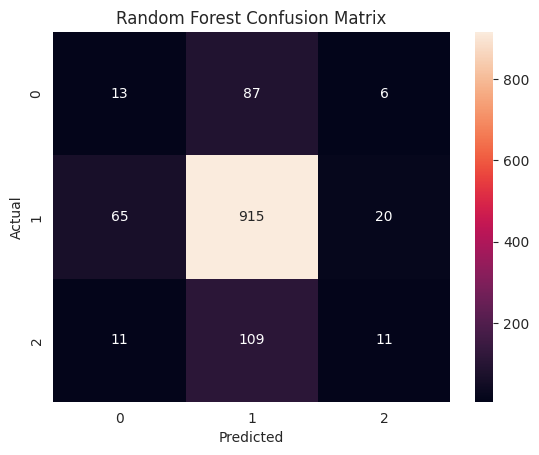

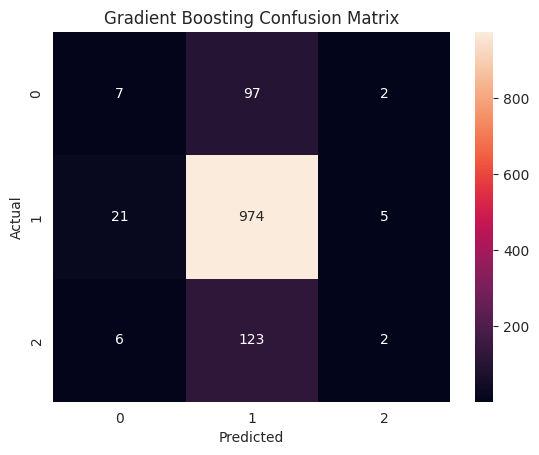

In [67]:
models = {
    'Random Forest': rf_pred,
    'Gradient Boosting': gb_pred,
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


**Explanation:**

- **Confusion Matrix:** Visualizes the performance of an algorithm.
- **True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN):** Helps identify where the model is making mistakes.




---

## **8. Hyperparameter Tuning**

We perform hyperparameter tuning using GridSearchCV to find the best combination of parameters the Random Forest Classifier and GB, aiming to improve their performance.

### **8.1. Hyperparameter Tuning for RF**


In [68]:
# Integrating SMOTE with Pipeline and GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Pre-sample data
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Simplify parameter grid
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10],
}

# Define pipeline
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Use RandomizedSearchCV
grid_search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=5,  # Limit to 5 combinations
    cv=3,  # Use 3 folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit Grid Search
grid_search_rf.fit(X_train_smote, y_train_smote)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_


Best parameters for Random Forest: {'classifier__n_estimators': 100, 'classifier__max_depth': None}


**Explanation:**

- **Pipeline:** Combines SMOTE oversampling and the classifier into a single pipeline.
- **Parameter Grid:** Adjusted to reference the classifier within the pipeline using classifier__ prefix.
- **GridSearchCV:** Now tunes the Random Forest hyperparameters while handling class imbalance with SMOTE.

### **8.2. Hyperparameter Tuning for GB**

In [69]:
# Simplified parameter grid
param_grid_gb = {
    'classifier__n_estimators': [20, 50],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [3],
    'classifier__subsample': [0.8],
}

# Define pipeline
pipeline_gb = Pipeline([
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# RandomizedSearchCV with minimal iterations
grid_search_gb = RandomizedSearchCV(
    estimator=pipeline_gb,
    param_distributions=param_grid_gb,
    n_iter=3,  # Very small number of iterations
    cv=2,      # Fewer CV folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit Grid Search
grid_search_gb.fit(X_train_smote, y_train_smote)

print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
best_gb_model = grid_search_gb.best_estimator_

Best parameters for Gradient Boosting: {'classifier__subsample': 0.8, 'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}


**Explanation:**

- **Parameter Grid:** Defines the hyperparameters to be tuned.
- **Time Series Cross-Validation:** Ensures that future data is not used in training.
- **GridSearchCV:** Searches for the best combination of hyperparameters.


## **8.3. Making Predictions for tuned model**

In [70]:
best_rf_pred = best_rf_model.predict(X_test)
best_gb_pred = best_gb_model.predict(X_test)

## **8.4 Classification reports for tuned model**

In [71]:
print("Random Forest Classification Report:")
print(classification_report(y_test, best_rf_pred))

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, best_gb_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.11      0.36      0.17       106
           0       0.85      0.55      0.67      1000
           1       0.14      0.27      0.18       131

    accuracy                           0.50      1237
   macro avg       0.37      0.39      0.34      1237
weighted avg       0.71      0.50      0.57      1237

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          -1       0.12      0.42      0.19       106
           0       0.85      0.56      0.67      1000
           1       0.10      0.16      0.12       131

    accuracy                           0.50      1237
   macro avg       0.36      0.38      0.33      1237
weighted avg       0.71      0.50      0.57      1237





## **9. Strategy Backtesting**

We simulate trading strategies based on the model predictions.

### **9.1. Adding Predictions to DataFrame**


In [72]:
df_test = df.iloc[:len(X_test)].reset_index(drop=True)
df_test['Pred_RF'] = rf_pred
df_test['Pred_GB'] = gb_pred
df_test['Pred_RF_Tuned'] = best_rf_pred
df_test['Pred_GB_Tuned'] = best_gb_pred


**Explanation:**

- **Data Alignment:** Ensures predictions align with the correct dates.
- **Adding Predictions:** Appends model predictions to the test DataFrame.

### **9.2. Calculating Strategy Returns & Cumulative Returns**


In [73]:
df_test['Return'] = df_test['Last_Close'].pct_change()

models = ['Pred_RF', 'Pred_GB', 'Pred_RF_Tuned', 'Pred_GB_Tuned']

for model in models:
    df_test[f'Strat_Return_{model}'] = df_test['Return'] * df_test[model].shift(1)
    df_test[f'Cum_Return_{model}'] = (1 + df_test[f'Strat_Return_{model}']).cumprod()

df_test['Cum_Return_BuyHold'] = (1 + df_test['Return']).cumprod()


## **9.3. Visualization of Results**

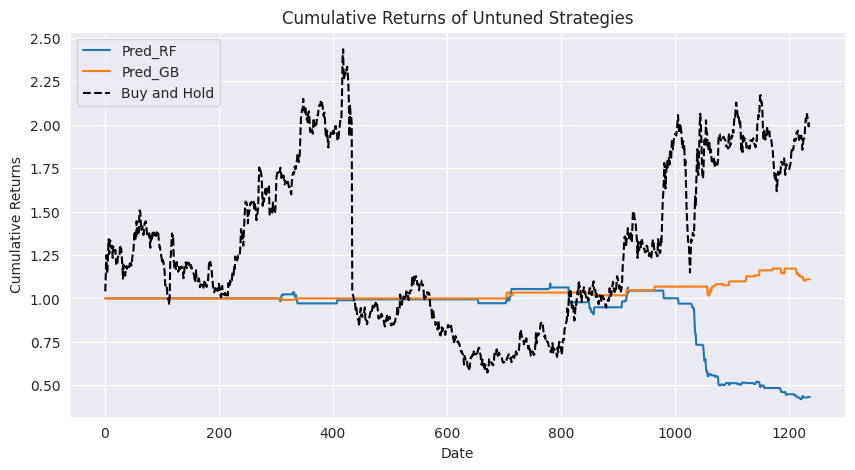

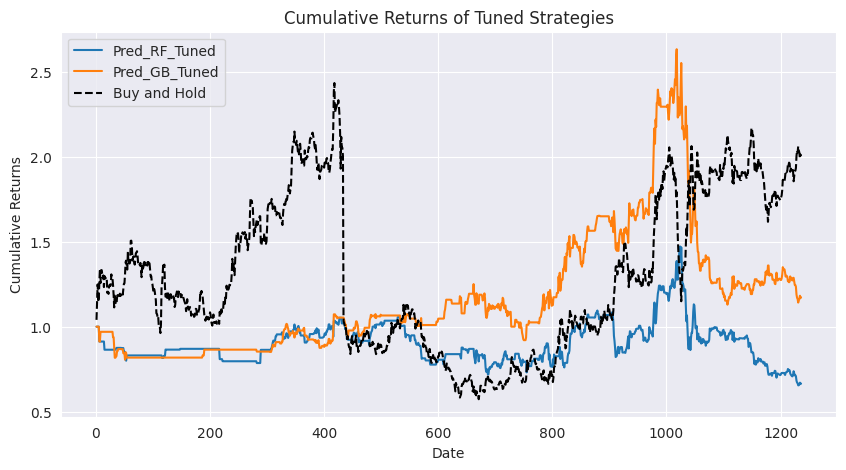

In [74]:
# Untuned Models
plt.figure(figsize=(10, 5))
untuned_models = ['Pred_RF', 'Pred_GB']  # Specify untuned models

for model in untuned_models:
    plt.plot(df_test.index, df_test[f'Cum_Return_{model}'], label=f'{model}')

plt.plot(df_test.index, df_test['Cum_Return_BuyHold'], label='Buy and Hold', color='black', linestyle='--')
plt.title('Cumulative Returns of Untuned Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Tuned Models
plt.figure(figsize=(10, 5))
tuned_models = ['Pred_RF_Tuned', 'Pred_GB_Tuned']  # Specify tuned models

for model in tuned_models:
    plt.plot(df_test.index, df_test[f'Cum_Return_{model}'], label=f'{model}')

plt.plot(df_test.index, df_test['Cum_Return_BuyHold'], label='Buy and Hold', color='black', linestyle='--')
plt.title('Cumulative Returns of Tuned Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


**Explanation:**

- **Plotting:** Visual comparison of strategy performance.
- **Interpretation:** Helps identify which model performs best.

### **9.4. Comparing Final Returns**


In [75]:
final_returns = {model: df_test[f'Cum_Return_{model}'].iloc[-1] for model in models}
final_returns['BuyHold'] = df_test['Cum_Return_BuyHold'].iloc[-1]

print("Final Cumulative Returns:")
for model, ret in final_returns.items():
    print(f"{model}: {ret:.2f}")


Final Cumulative Returns:
Pred_RF: 0.43
Pred_GB: 1.11
Pred_RF_Tuned: 0.67
Pred_GB_Tuned: 1.17
BuyHold: 2.01


**Explanation:**

- **Final Returns:** Quantifies the total return for each strategy.
- **Comparison:** Assesses which strategy yielded the highest return.

## **10. Conclusion**

**Findings:**

* Models performed poorly compared to the "Buy and Hold" benchmark, with cumulative returns failing to exceed market trends.

* Class imbalance in the dataset heavily influenced predictions, favoring the majority class and leading to poor performance on minority classes.

* The "Buy and Hold" strategy remains a strong benchmark, especially in markets with a general upward trend.

**Limitations:**

* Class imbalance reduced model effectiveness, particularly for minority classes critical to profitable trades.

* The backtesting framework did not include real-world constraints like transaction costs and slippage.

* Models lacked robustness in volatile or unseen market conditions.

**Future Work:**

* Address class imbalance with techniques like oversampling (e.g., SMOTE) or cost-sensitive learning.

* Introduce advanced time-series models like LSTMs or Prophet to capture temporal dependencies.

* Expand backtesting to include real-world constraints for a more realistic evaluation.